# 誤差逆伝播法

「誤差伝播法ってなぁに？」  
「ニューラルネットワークの学習時に、パラメータの勾配を求める為の手法だよ」

## 合成関数の微分

高校でやるやつ。これが分かれば誤差逆伝播法なんてほとんど理解したようなもん

<br>

試しに、以下の関数を微分してみよう。

$$
y = (x + 1)^2
$$

これは普通に展開しても解けるけど、合成関数の微分を使っても解けるね

$$
u = x + 1 \\
y = u^2 \\
\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx} = 2u \cdot 1 = 2(x + 1)
$$

こんな感じで、**関数の関数**(合成関数)を微分するときは、関数ごとに微分をしたものをかけ合わせればよかった

<br>

じゃあここまでの流れをPythonで実装してみよう

以下の二つの関数を`class`として実装する。
- $f(x) = x + 1$
- $g(x) = x^2$

`class`にする必要ある？関数でよくね？と思うかもしれんけど、まあ読んでみてよ。  
まずは$f(x) = x + 1$から

In [1]:
class Plus1:
    def __call__(self, x):
        return x + 1

出来た。入力した値に1を足して出力するだけの関数。`__call__()`というのは特殊メソッドで、関数のように`()`をつけて呼び出したときに実行されるヤツ。  
こんな感じ

In [2]:
plus1 = Plus1() # インスタンス生成
y = plus1(3) # # __call__メソッドの呼び出し
print(y)

4


入力した3に1を足した4が出力された。

では、今度は微分を行うメソッドを書いてみよう。「微分を行う」というのを、「(`backward()`に)入力された値に微分した値をかけて出力する」と捉えるとこうなる

In [3]:
class Plus1:
    def __call__(self, x):
        return x + 1

    def backward(self, d):
        return d * 1

`backward()`というメソッドを追加した。  
$x + 1$を$x$で微分すると1になるので、入力値(d)に1をかけて出力させる。

こんなノリで、$g(x) = x^2$の方も書いちゃおう

In [4]:
class Square:
    def __call__(self, x):
        self.x = x
        return x ** 2

    def backward(self, d):
        return d * self.x*2

できた。$g(x)$を$x$で微分すると$2x$になるので、それを入力値(d)にかけて出力する。微分するときに使うので、初めに入力された値(x)は変数に保存しておく。  
こんな感じに、`backward()`を追加したり、値を一時的に保存したりしたかったから、classとして実装したのだ

<br>

ちなみに、`__call__()`で行なっている演算は**順伝播**  
`backward()`で行なっている演算は**逆伝播**という

あと、順伝播(`__call__()`)への入力と逆伝播(`backward()`)への入力が混ざる気がするので、今後以下のように区別する。  
- 順伝播への入力: **入力(x)**
- 逆伝播への入力: **入力(d)**

<br>

ではこれらを使って、実際に計算してみよう。  

ここから、

$$
h(x) = (x + 1)^2
$$

としよう

まずは順伝播から

In [5]:
# インスタンス生成
plus1 = Plus1()
square = Square()

# 計算
x = 3
u = plus1(x)
y = square(u)
print(y)

16


ほい。$h(3) = 16$ということで、正解！

じゃあ今度は逆伝播で、$h$の$x=3$での傾きを求めてみよう。$h'(3)$のことだね。  
そしてこれはこんな感じで求められる

In [6]:
d = square.backward(1)
d = plus1.backward(d)
print(d)

8


$$
h'(x) = 2(x + 1) \\
h'(3) = 8
$$

ということで正解！  
これは合成関数の微分に基づいていて、正に「関数ごとの微分を掛け合わせる」という部分に当たるね！

> 入力された値に微分した値をかけて出力する

さっきこう捉えた意味が分かったかな...?  
微分した結果を逆方向に伝えていく感じだね。一番初めは1を入力しておく。

## ニューラルネットワークの構築

見てもらった通り、複数の関数を経て出力された値を何らかの変数で微分した値は、関数ごとに微分をすれば簡単に求まる。  
んで、これはニューラルネットワークが持つパラメータの勾配を求めるときにも使える。

損失をパラメータで微分した値(勾配)を求めるとき、損失を出す際に通った**層**や**損失関数**を一つ一つ微分すればいいよねという話。

<br>

じゃあ、誤差逆伝播法で学習を行うニューラルネットワークを実際に作ってみようじゃないか

In [7]:
import numpy as np

### 層の定義

NNは複数の層から構成されるので、まずは層を作る。

#### ReLU

重みとかバイアスみたいなパラメータを持つ層は工夫が必要なので、一旦パラメータを持たない層を作ってみよう。  
さっきの関数と同じように作ればOK

ちなみにReLUはこういう関数

$$
y = \begin{cases}
x & (x > 0) \\
0 & (x \leq 0) \\
\end{cases}
$$

In [8]:
class ReLU:
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, d):
        return d * (self.x > 0)

    def update(self, lr):
        pass

できた。bool型は`+`とか`*`みたいな演算子と一緒に使うと0,1として扱ってくれるので、`backward()`はこういう書き方でOK。入力が0を超えてたら傾き1、それ以外は0。

さっき実装したような一般的な関数の入出力は「数値」だけど、NNの層の入出力は「ベクトル（というかテンソル）」で行うのでnumpyを使うよ  
あと、後々のことを考えて、パラメータを更新するメソッド`update()`を書いている。ReLUはパラメータを持たないので何もしないけど

#### 全結合層

全結合層。kerasでいうDense。PyTorchでいうLinear。ここではPyTorchに倣ってLinearにしよー

In [9]:
class Linear:
    def __init__(self, n_input, n_output):
        self.w = np.random.normal(size=(n_input, n_output), scale=np.sqrt(2/n_output))
        self.b = np.random.randn(n_output)

    def __call__(self, x):
        self.x = x
        return np.dot(x, self.w) + self.b

    def backward(self, d):
        self.grad_w = np.multiply(*np.meshgrid(d, self.x))
        self.grad_b = d
        return np.dot(d, self.w.T)

    def update(self, lr):
        self.w -= lr * self.grad_w
        self.b -= lr * self.grad_b

できた。ミニバッチは非対応にした。そのせいで`grad_w`が複雑になっているけど、「逆伝播」についてはミニバッチじゃない方が分かりやすい気がしたので。

パラメータを持つ層なので、`__init__()`でパラメータを初期化している。  
重みもバイアスも正規分布に従って初期化してるけど、重みの初期化は`randn()`ではなく`normal()`を使っている。  
`randn()`だと標準偏差が1になるんだけど、それだと重みが大きくなりすぎて上手くいかなかったので、小さくしてる。詳しくは**Xaivierの初期化**とかでググってみて。

`backward()`は、入力(d)を各パラメータで微分して変数に入れておく。  
それらはパラメータの勾配となるので、`update()`(パラメータ更新)の時は、それらに学習率をかけてパラメータから引く感じ。

<br>

< `backward()`(逆伝播)について >

まず、あるニューロンに対する順伝播時の入力(x)を$x$、出力を$y$、重みを$w$、バイアスを$b$として、これらの関係を表す。

$$
w \cdot x + b = y
$$

内積にバイアスを足しているね

これを踏まえて、ここ(逆伝播)で求める値を説明する。求める値は3つ。

- 重みの勾配(grad_w)

$l$番目の入力($x_l$)から$m$番目の出力($y_m$)への重みを$w_{lm}$とすると、求めたいのは$y$を$w_{lm}$で微分したもの。  
で、それは入力(d)に$x_l$をかけたものになる。$l, m$ではない部分やバイアスは微分をする上で関係ないので無視してよくて、残るのは$x_l \times w_{lm}$の部分だけという感じ。これを$w_{lm}$で微分すると$x_l$だけ残る。

これを全ての$l, m$で求めるのがこのコード: `np.multiply(*np.meshgrid(self.x, d))`  
これは、全部の組み合わせで掛け算をしているだけ。↓の例を見て理解してくれ。

```python
a = [1, 2, 3]
b = [4, 5]
y = np.multiply(*np.meshgrid(a, b))
print(y)

>> [[ 4  8 12]
    [ 5 10 15]]
```

(これ一発でできる関数とか知っている人いたら教えてほしい...)


- バイアスの勾配(grad_b)

バイアスで微分する上で内積の部分は関係ないので無視してよい。上の式を$b$で微分すると1なので、バイアス(b)の勾配は、入力(d)に1をかけたd

- 入力(x)の勾配(return)

ある一つの入力(x)に着目する。この入力(x)は$x_i$としよう。んで、$x_i$は層の全てのニューロン(の演算)に関わっている。  
ここで、層のニューロンの数が一つだと仮定しよう。そうすると話は簡単。重みの勾配を求めたときと逆のことをすればいいので、$x_i$の勾配はそこに対応する重み$w_i$となる。  
でも実際は層のニューロンが複数あるので、勾配が複数出てきそう。そんなときにどうすればよいか。

これは、実はとってもシンプルで、出てきた勾配を全部足せばよい。で、それは行列の積で上手くまとめられて、それがこれ: `np.dot(d, self.w.T)`


### ニューラルネットワーク

ではこれらを組み合わせてNNをつくろー

In [10]:
class NeuralNetwork:
    def __init__(self, *layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, d):
        for layer in self.layers[::-1]:
            d = layer.backward(d)

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

できた。これだけ。かんたん。  
使い方は、インスタンス生成時にレイヤーを入れていくだけ。kerasとかPyTorchでいうSequentialみたいな感じ。以下メソッドの説明

- `__call__()`  
順伝播。与えた層で順番に演算しているだけ。

- `backward()`  
逆伝播。リストに`[::-1]`をつけると逆順になる

- `update()`  
パラメータ更新。逆伝播で求めた勾配に学習率をかけてパラメータから引く。ここをシンプルにするために、パラメータを持たない層にもこのメソッドを書いておいた。

<br>

試しに使ってみよう

In [11]:
nn = NeuralNetwork(
    Linear(5, 32),
    ReLU(),
    Linear(32, 10,)
)

モデルの構築はこれでOK。入力する値は5個、出てくる値は10個。適当に乱数を5個入れてみると

In [12]:
x = np.random.randn(5)
y = nn(x)
print(y)

[ 2.70924181 -1.15491763  2.64228401  1.00399676 -1.36650978 -2.33312378
  2.08624605 -0.2996883   0.48605541  2.26515702]


適当な値が10個出てきた。おーけー

### 損失関数

損失関数もクラスとして書いてみよう

#### 二乗和誤差

差の二乗の和...を、2で割ったもの。

$$
\frac{1}{2} \sum_{i} (y_i - t_i)^2
$$


なんで2で割るかって？　微分した時に綺麗になるからだよ〜

In [13]:
class RSS:
    def __call__(self, y, t):
        self.y = y
        self.t = t
        return np.sum((y - t) ** 2) / 2

    def backward(self):
        return self.y - self.t

`backward()`の中身、綺麗でしょ〜。微分すると二乗の部分が前に出てくるので、$\frac{1}{2}$と打ち消し合っていい感じになる  
あと、ここの逆伝播では何も入力しない。逆伝播の一番最初の部分だから入力はないね。

#### 交差エントロピー

分類タスクで使うやつ。これを使うときは、出力層の活性化関数はsoftmaxを使う。ので、それも一緒に書いちゃおう！

In [14]:
class CrossEntropy:
    def __call__(self, y, t):
        y = self._softmax(y)
        self.y = y
        self.t = t
        loss = -np.sum(t * np.log(y))
        return loss

    def backward(self):
        return self.y - self.t

    def _softmax(self, y):
        return np.exp(y) / np.sum(np.exp(y))

できた。これも、逆伝播がとってもきれいな形。普通活性化関数はNN側に書くけど、交差エントロピーと一緒に使うとこの部分の微分が綺麗になるので、こっちに書いた。  
微分がきれいなのはたまたまではなく、頭のいい人が綺麗になるように考えたからだと思う。

<br>

二つの損失関数を書いたけど、どちらも逆伝播が「予測値-正解」になっているね。  
勾配を求めるときは、これをNNに入れて逆伝播を行うんだけど、「予測値-正解」って、正解と予測値の差だから、「誤差」と表せるよね。

「誤差逆伝播法」の由来が分かった気がするね

## 学習

では実際に学習させてみよう。定番のMNIST。

In [15]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 正規化
x_train = x_train.reshape(-1, 784) / 255
x_test = x_test.reshape(-1, 784) / 255

# one-hotに
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

2022-10-20 00:19:22.331455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 00:19:22.455261: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 00:19:22.954952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib64:
2022-10-20 00:19:22.955084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

確率的勾配降下法で学習させる。ミニバッチに対応していないので、バッチサイズは1

In [16]:
from tqdm import tqdm

def train(model, x, y, criterion, lr, n_epochs):
    for epoch in range(1, n_epochs+1):
        loss = 0
        for _ in tqdm(range(len(x)), desc=f'{epoch}epoch'):
            # ランダムに一つ抽出
            idx = np.random.randint(0, len(x))
            sample_x = x[idx]
            sample_y = y[idx]

            out = model(sample_x) # 順伝播
            loss += criterion(out, sample_y) # 損失の計算
            d = criterion.backward() # 損失関数の逆伝播
            model.backward(d) # ニューラルネットワークの逆伝播
            model.update(lr) # パラメータの更新
        print(f'loss: {loss / len(x)}')

ネットワーク構成は適当！

In [17]:
nn = NeuralNetwork(
    Linear(784, 512),
    ReLU(),
    Linear(512, 128),
    ReLU(),
    Linear(128, 10),
)

レッツゴー

In [18]:
train(nn, x_train, y_train, CrossEntropy(), 0.001, 5)

1epoch: 100%|██████████| 60000/60000 [01:55<00:00, 517.45it/s]


loss: 0.2695821597613696


2epoch: 100%|██████████| 60000/60000 [01:56<00:00, 516.60it/s]


loss: 0.10846042071623153


3epoch: 100%|██████████| 60000/60000 [01:55<00:00, 521.15it/s]


loss: 0.07909254203673934


4epoch: 100%|██████████| 60000/60000 [01:54<00:00, 523.02it/s]


loss: 0.05543957445079766


5epoch: 100%|██████████| 60000/60000 [01:53<00:00, 529.67it/s]

loss: 0.04660230423813134


私の環境では、1エポックに2分ぐらいだった。cpuなので、こんなもん。

いい感じにlossが減っているので上手くいってそう。確認してみよう。

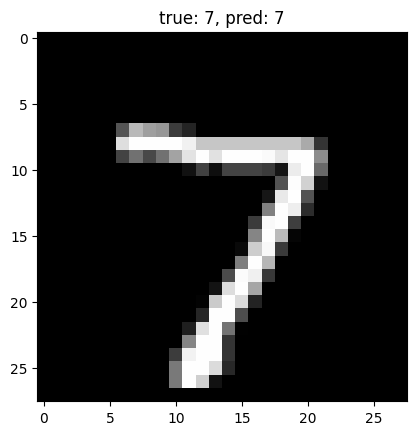

In [19]:
import matplotlib.pyplot as plt

sample_x = x_test[0]
sample_y = y_test[0]
t = np.argmax(sample_y)
pred = np.argmax(nn(sample_x))
plt.title(f'true: {t}, pred: {pred}')
plt.imshow(sample_x.reshape(28, 28), cmap='gray');

ちゃんと7と予測できているね。

精度も確かめてみよう

In [20]:
predicts = np.array([nn(x).argmax() for x in x_test])
y_test = y_test.argmax(axis=1)
print('accuracy:', (predicts == y_test).mean())

accuracy: 0.9728


バッチリ